# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [93]:
!pip install keras --upgrade

In [94]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [95]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [96]:
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [97]:
file_id = '1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W'

download_file(file_id, 'car_images.zip')

car_images.zip 파일이 이미 존재합니다.


#### 2) 데이터 압축 해제

In [98]:
def dataset_extract(file_name):
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'/content/{file_name[-14:-4]}'):
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc='Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'/content/{file_name[-14:-4]}/')


In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
dataset_extract('/content/drive/MyDrive/미니프로젝트4차/Car_Images.zip')

데이터셋 폴더가 이미 존재합니다.


#### 2) 데이터 조회

In [101]:
# 폴더별 이미지 데이터 갯수 확인
path = '/content/Car_Images/'

print( f'정상 차량 이미지 수 : {len(glob.glob(path+"normal/*"))}' )
print( f'파손 차량 이미지 수 : {len(glob.glob(path+"abnormal/*"))}' )

정상 차량 이미지 수 : 302
파손 차량 이미지 수 : 303


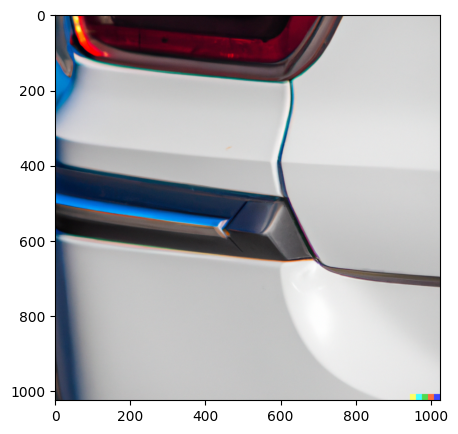

이미지의 형태는 다음과 같다 : (1024, 1024, 3)


In [102]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인

rand_n = np.random.randint( 0, len(glob.glob(path+"normal/*"))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+"normal/*")[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지의 형태는 다음과 같다 : {img.shape}')

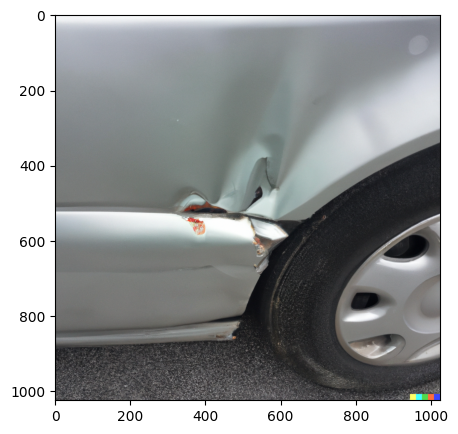

이미지의 형태는 다음과 같다 : (1024, 1024, 3)


In [103]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인

rand_n = np.random.randint( 0, len(glob.glob(path+"normal/*"))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+"abnormal/*")[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지의 형태는 다음과 같다 : {img.shape}')

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [104]:
len(glob.glob(path+"normal/*")), len(glob.glob(path+"abnormal/*"))

(302, 303)

In [105]:
# 정상 차량은 0, 파손 차량은 1
y_normal = np.zeros((302,))
y_abnormal = np.ones((303,))

# 정상 차량 어레이와 파손 차량 어레이 합치기
y_total = np.hstack((y_normal, y_abnormal))
y_total.shape

(605,)

In [106]:
y_total[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [107]:
x_total_list = glob.glob(path+"normal/*") + glob.glob(path+"abnormal/*")
x_total_list[:3]

['/content/Car_Images/normal/DALLíñE 2023-03-10 18.52.40 - photo of a part of car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-11 14.25.21 - part of a car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-11 14.32.34 - part of a car.png']

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
# training set, test set 분리
x_train, x_test, y_train, y_test =\
    train_test_split(x_total_list, y_total, test_size=0.1, random_state=2024)

x_train, x_val, y_train, y_val =\
    train_test_split(x_train, y_train, test_size=0.1, random_state=2024)

In [110]:
len(x_train), y_train.shape, len(x_val), y_val.shape

(489, (489,), 55, (55,))

In [111]:
x_train

['/content/Car_Images/abnormal/DALLíñE 2023-03-11 15.08.02 - dents of a car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-11 14.27.59 - part of a car.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.45.06 - slightly dented car.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.42.29 - slightly dented car.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.45.54 - scratched car.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 17.18.29 - scratched car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-10 22.37.34 - photo of a part of car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-11 01.28.20 - a part of a car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-11 00.51.42 - photo of a part of car.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.42.01 - slightly dented car.png',
 '/content/Car_Images/normal/DALLíñE 2023-03-11 00.58.41 - photo of a part of car.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 14.57.28 - dents of a

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [112]:
import keras

In [113]:
def x_preprocessing(img_list) :
    bin_list = []

    for img in tqdm(img_list) :
        img = keras.utils.load_img(img, target_size=(128,128) )
        img = keras.utils.img_to_array(img)
        bin_list.append(img)

    return np.array(bin_list)

In [114]:
x_tr_arr = x_preprocessing(x_train)
x_val_arr = x_preprocessing(x_val)
x_te_arr = x_preprocessing(x_test)

100%|██████████| 61/61 [00:04<00:00, 12.33it/s]


In [115]:
x_tr_arr.shape, x_val_arr.shape, x_te_arr.shape

((489, 128, 128, 3), (55, 128, 128, 3), (61, 128, 128, 3))

In [116]:
x_tr_arr.shape, y_train.shape

((489, 128, 128, 3), (489,))

In [117]:
x_tr_arr

array([[[[168., 148., 137.],
         [163., 151., 140.],
         [163., 147., 137.],
         ...,
         [106., 103., 103.],
         [106., 105., 104.],
         [107., 105., 102.]],

        [[171., 155., 141.],
         [171., 154., 142.],
         [169., 152., 143.],
         ...,
         [103., 103., 101.],
         [104., 103., 101.],
         [104., 103., 100.]],

        [[169., 153., 138.],
         [169., 151., 139.],
         [168., 151., 137.],
         ...,
         [107., 106., 101.],
         [108., 108., 105.],
         [106., 105., 105.]],

        ...,

        [[ 32.,  24.,  21.],
         [ 31.,  26.,  22.],
         [ 31.,  27.,  25.],
         ...,
         [ 20.,  20.,  21.],
         [ 16.,  17.,  16.],
         [ 17.,  17.,  16.]],

        [[ 31.,  24.,  22.],
         [ 35.,  26.,  23.],
         [ 29.,  22.,  18.],
         ...,
         [255., 110.,  60.],
         [ 60.,  70., 255.],
         [ 60.,  70., 255.]],

        [[ 31.,  28.,  23.],
       

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

In [118]:
import keras

from keras.utils import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D, RandomRotation

In [119]:
# 1 세션 클리어
clear_session()

# 2 모델 발판 생성
model1 = Sequential()

# 3 레이어 블록 조립
model1.add( Input(shape=(128,128,3)) )
################################
# model.add( RandomRotation(0.2) )
################################
model1.add( Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model1.add( Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model1.add( MaxPool2D((2,2), (2,2)) )
model1.add( BatchNormalization() )
model1.add( Dropout(0.4) )

model1.add( Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model1.add( Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model1.add( MaxPool2D((2,2), (2,2)) )
model1.add( BatchNormalization() )
model1.add( Dropout(0.4) )

model1.add( Flatten() )
model1.add( Dense(1, activation='sigmoid') )

# 4 컴파일
model1.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [120]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,489 (513.63 KB)

 Trainable params: 131,297 (512.88 KB)

 Non-trainable params: 192 (768.00 B)

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

In [122]:
es = EarlyStopping(monitor='val_loss',       # 얼리스토핑 적용 대상
                   min_delta=0,              # 임계값.
                   patience=10,               # 몇 번 더 지켜볼래.
                   verbose=1,
                   restore_best_weights=True # 최적의 가중치로 돌려줌.
                   )

#### 2) 학습

In [123]:
model1.fit(x_tr_arr, y_train, validation_data=(x_val_arr, y_val),
          epochs=10000, verbose=1,
        #   validation_split=0.2,
          callbacks=[es]
          )

Epoch 1/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.7805 - loss: 0.9228 - val_accuracy: 0.5636 - val_loss: 2.0117
Epoch 2/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8507 - loss: 0.5588 - val_accuracy: 0.4727 - val_loss: 5.9526
Epoch 3/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8577 - loss: 0.4888 - val_accuracy: 0.4545 - val_loss: 9.2032
Epoch 4/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9110 - loss: 0.3350 - val_accuracy: 0.7455 - val_loss: 0.6590
Epoch 5/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9022 - loss: 0.2755 - val_accuracy: 0.4727 - val_loss: 3.0210
Epoch 6/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9722 - loss: 0.0590 - val_accuracy: 0.6545 - val_loss: 1.5712
Epoch 7/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9712 - loss: 0.0786 - val_accuracy: 0.8727 - val_loss: 0.4451
Epoch 8/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9561 - loss: 0.1283 

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [124]:
y_pred = model1.predict(x_te_arr)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


In [125]:
y_pred

array([[9.9751592e-01],
       [9.8147249e-01],
       [3.4350108e-03],
       [1.3047829e-01],
       [9.8665756e-01],
       [9.7545731e-01],
       [7.4087554e-01],
       [1.6041256e-01],
       [5.9387549e-03],
       [5.7721132e-05],
       [9.6638829e-01],
       [4.8005726e-02],
       [3.4046018e-01],
       [2.0744601e-02],
       [5.9229940e-01],
       [7.4310973e-02],
       [4.5942706e-05],
       [1.5458498e-03],
       [1.3784105e-03],
       [2.6272872e-02],
       [5.5602080e-01],
       [9.9999881e-01],
       [6.4965822e-02],
       [9.6964413e-01],
       [9.6028566e-02],
       [9.9896312e-01],
       [6.2680249e-03],
       [6.3988714e-10],
       [9.8422837e-01],
       [9.9832028e-01],
       [9.4100839e-01],
       [9.9968642e-01],
       [1.6086867e-06],
       [1.3563610e-04],
       [9.9935812e-01],
       [9.9487877e-01],
       [2.9412872e-04],
       [5.5201996e-02],
       [6.1777597e-03],
       [1.2565972e-02],
       [9.9987185e-01],
       [6.590345

In [126]:
y_pred_1 = np.where(y_pred >= 0.5, 1, 0)
# test_y_arg = np.argmax(y_test, axis=1)

In [127]:
y_pred_1

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [128]:
y_pred_2 = y_pred_1.flatten()

In [129]:
y_pred_2

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])

In [130]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [131]:
accuracy_score(y_test, y_pred_2)

0.8360655737704918

In [132]:
print( classification_report(y_test, y_pred_2) )

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84        33
         1.0       0.80      0.86      0.83        28

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [133]:
print(confusion_matrix(y_test, y_pred_2) )

[[27  6]
 [ 4 24]]


## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

In [ ]:
# import tensorflow as tf

# # 데이터셋이 위치한 디렉토리 경로
# dataset_dir = 'path/to/dataset'

# # 훈련 데이터셋 생성
# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     directory=dataset_dir,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(180, 180),
#     batch_size=32)

# # 검증 데이터셋 생성
# validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     directory=dataset_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(180, 180),
#     batch_size=32)


In [161]:
import tensorflow as tf
train_data, val_data = tf.keras.preprocessing.image_dataset_from_directory(directory='/content/Car_Images',
                                    label_mode='categorical',
                                    color_mode='rgb',
                                    image_size=(128,128),
                                    seed=2024,
                                    validation_split=0.1,
                                    subset='both'
                                    )

Found 605 files belonging to 2 classes.
Using 545 files for training.
Using 60 files for validation.


### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [134]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D

In [142]:
clear_session()

# 이미지 증강 레이어 생성
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])

# Inception V3 모델 불러오기 (포함된 전처리 레이어 사용)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)  # 이미지 증강 적용
x = preprocess_input(x)  # Inception V3 전처리 적용


base_model = InceptionV3(weights='imagenet',       # ImageNet 데이터를 기반으로 미리 학습된 가중치 불러오기
                         include_top=False,        # InceptionV3 모델의 아웃풋 레이어는 제외하고 불러오기
                         input_shape= (128,128,3)) # 입력 데이터의 형태

x = base_model(x, training=False)

new_output = GlobalAveragePooling2D()(x)
new_output = Dense(1, # class 2개   클래스 개수만큼 진행한다.
                  activation = 'sigmoid')(new_output)

model = keras.models.Model(inputs, new_output)

model.summary()

# 4 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 21,770,401 (83.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [154]:
from keras.utils import plot_model

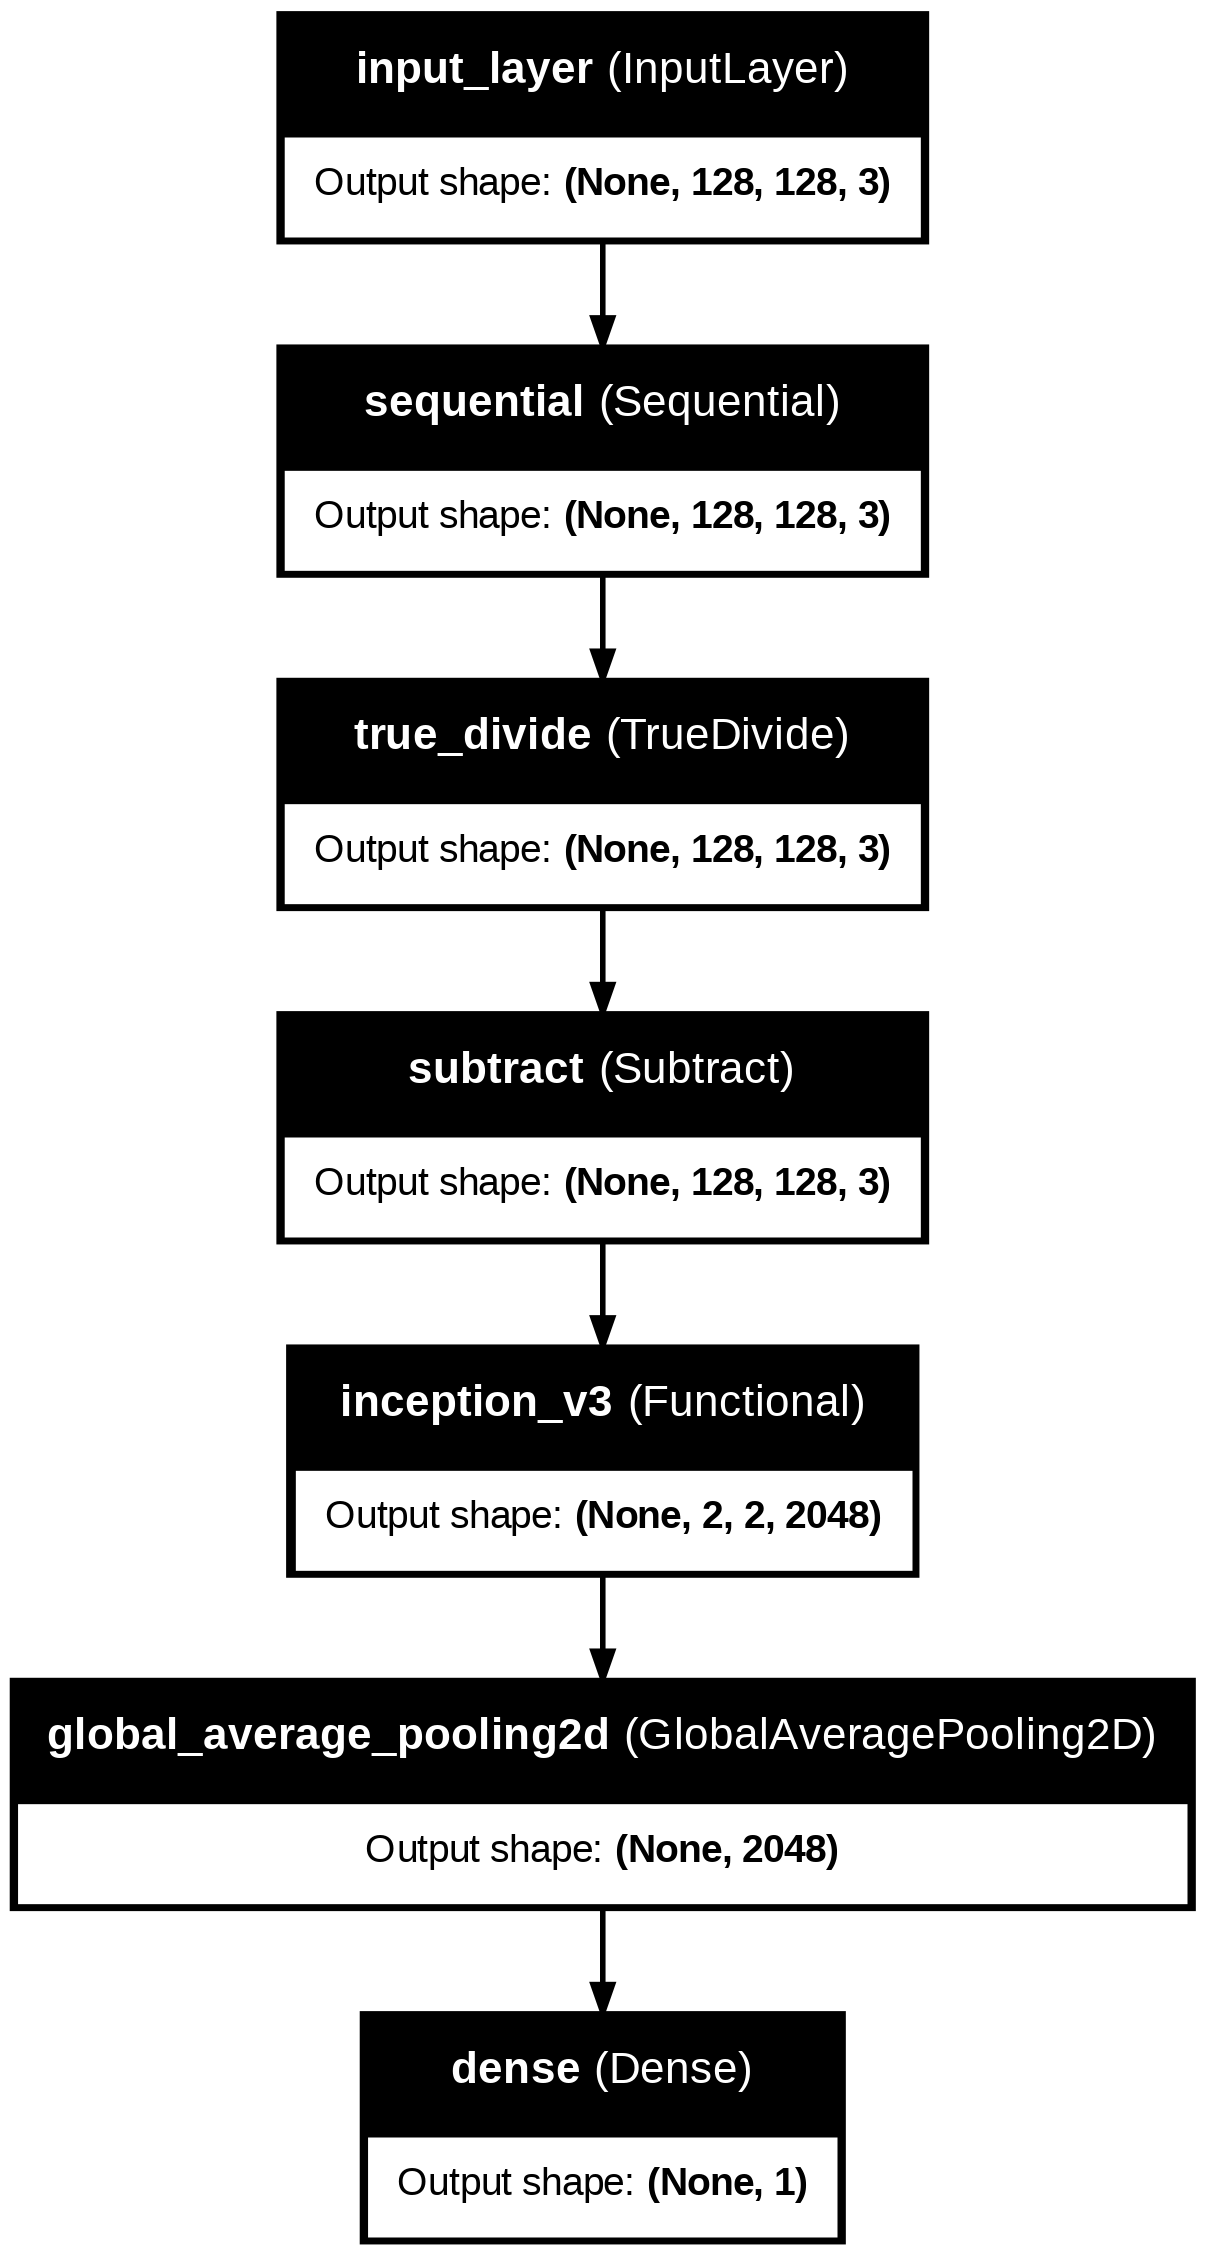

In [155]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [1]:
print(f'모델의 레이어 수 : {len(model.layers)}')

NameError: name 'model' is not defined

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

#### 3) 학습

In [136]:
es = EarlyStopping(monitor='val_loss',       # 얼리스토핑 적용 대상
                   min_delta=0,              # 임계값.
                   patience=10,               # 몇 번 더 지켜볼래.
                   verbose=1,
                   restore_best_weights=True # 최적의 가중치로 돌려줌.
                   )

In [143]:
model.fit(x_tr_arr, y_train, validation_data=(x_val_arr, y_val),
          epochs=10000, verbose=1,
        #   validation_split=0.2,
          callbacks=[es]
          )

Epoch 1/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 717ms/step - accuracy: 0.7258 - loss: 0.6383 - val_accuracy: 0.5818 - val_loss: 2.2299
Epoch 2/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.8234 - loss: 0.4540 - val_accuracy: 0.5091 - val_loss: 10.8968
Epoch 3/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9153 - loss: 0.2758 - val_accuracy: 0.4909 - val_loss: 82.4384
Epoch 4/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8507 - loss: 0.3435 - val_accuracy: 0.4909 - val_loss: 6.5192
Epoch 5/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9182 - loss: 0.2874 - val_accuracy: 0.4364 - val_loss: 5.6705
Epoch 6/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9136 - loss: 0.2335 - val_accuracy: 0.4727 - val_loss: 12.0189
Epoch 7/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8815 - loss: 0.3082 - val_accuracy: 0.6364 - val_loss: 1.2014
Epoch 8/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7528 - los

#### 4) 성능 평가

In [145]:
y_pred = model.predict(x_te_arr)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step


In [146]:
y_pred

array([[9.34700489e-01],
       [9.93735433e-01],
       [1.12150637e-02],
       [2.10288063e-01],
       [9.88242447e-01],
       [9.95479703e-01],
       [1.20849371e-01],
       [2.15987163e-03],
       [2.74455454e-03],
       [7.40527213e-02],
       [1.49095431e-02],
       [9.79949176e-01],
       [3.07654100e-03],
       [3.44063938e-01],
       [2.04425126e-01],
       [3.89730521e-05],
       [2.06034556e-02],
       [1.79433897e-01],
       [7.81173766e-01],
       [2.46481528e-03],
       [7.82883644e-01],
       [9.97704089e-01],
       [5.01392186e-02],
       [9.01313208e-04],
       [2.15785205e-02],
       [9.88626063e-01],
       [5.68081113e-03],
       [7.13411349e-18],
       [1.44274288e-03],
       [9.91713762e-01],
       [5.13431383e-04],
       [9.96838927e-01],
       [1.94049627e-02],
       [1.19898776e-02],
       [9.94871199e-01],
       [9.99972582e-01],
       [4.63682450e-02],
       [1.01639338e-01],
       [4.05731751e-03],
       [3.33021462e-01],


In [147]:
y_pred_1 = np.where(y_pred >= 0.5, 1, 0)
# test_y_arg = np.argmax(y_test, axis=1)

In [148]:
y_pred_2 = y_pred_1.flatten()

In [149]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [150]:
accuracy_score(y_test, y_pred_2)

0.9180327868852459

In [151]:
print( classification_report(y_test, y_pred_2) )

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93        33
         1.0       0.96      0.86      0.91        28

    accuracy                           0.92        61
   macro avg       0.92      0.91      0.92        61
weighted avg       0.92      0.92      0.92        61



In [152]:
print(confusion_matrix(y_test, y_pred_2) )

[[32  1]
 [ 4 24]]


#### 5) 학습_이미지데이터셋프롬디렉

In [166]:
clear_session()

# 이미지 증강 레이어 생성
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])

# Inception V3 모델 불러오기 (포함된 전처리 레이어 사용)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)  # 이미지 증강 적용
x = preprocess_input(x)  # Inception V3 전처리 적용


base_model = InceptionV3(weights='imagenet',       # ImageNet 데이터를 기반으로 미리 학습된 가중치 불러오기
                         include_top=False,        # InceptionV3 모델의 아웃풋 레이어는 제외하고 불러오기
                         input_shape= (128,128,3)) # 입력 데이터의 형태

x = base_model(x, training=False)

new_output = GlobalAveragePooling2D()(x)
new_output = Dense(2, # class 2개   클래스 개수만큼 진행한다.
                  activation = 'sigmoid')(new_output)

model3 = keras.models.Model(inputs, new_output)

model3.summary()

# 4 컴파일
model3.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,806,882 (83.19 MB)

 Trainable params: 21,772,450 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [167]:
model3.fit(train_data, validation_data = val_data,
          epochs=10000, verbose=1,
        #   validation_split=0.2,
          callbacks=[es]
          )

Epoch 1/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 674ms/step - accuracy: 0.7428 - loss: 0.5467 - val_accuracy: 0.5333 - val_loss: 12.0085
Epoch 2/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - accuracy: 0.9139 - loss: 0.2539 - val_accuracy: 0.5833 - val_loss: 17.4782
Epoch 3/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.9040 - loss: 0.2446 - val_accuracy: 0.5833 - val_loss: 82.6968
Epoch 4/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - accuracy: 0.9320 - loss: 0.2241 - val_accuracy: 0.5833 - val_loss: 62.1340
Epoch 5/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 448ms/step - accuracy: 0.9467 - loss: 0.1384 - val_accuracy: 0.5833 - val_loss: 119.9506
Epoch 6/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.9280 - loss: 0.2003 - val_accuracy: 0.5833 - val_loss: 66.3982
Epoch 7/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.9396 - loss: 0.1948 - val_accuracy: 0.8167 - val_loss: 2.3285
Epoch 8/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 523ms/step - accuracy: 0

#### 6) 성능 평가

In [197]:
y_pred = model3.predict(x_te_arr)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [198]:
y_pred

array([[9.93560910e-01, 8.44995677e-03],
       [9.99999881e-01, 1.15393760e-07],
       [1.88574431e-05, 9.99749839e-01],
       [9.84370038e-02, 9.19594765e-01],
       [9.99531806e-01, 4.15776653e-04],
       [1.00000000e+00, 2.44373877e-09],
       [9.97620404e-01, 2.54182052e-03],
       [6.34517074e-01, 3.41537207e-01],
       [1.28382680e-05, 9.99889612e-01],
       [7.88965821e-02, 9.15042162e-01],
       [9.11869854e-02, 9.21057642e-01],
       [2.07811981e-01, 8.06566298e-01],
       [8.93043471e-04, 9.97112274e-01],
       [9.89033341e-01, 1.14438040e-02],
       [1.15406135e-06, 9.99972343e-01],
       [7.65516340e-13, 1.00000000e+00],
       [3.55043705e-03, 9.97105539e-01],
       [4.30664532e-02, 9.58130956e-01],
       [9.87351537e-01, 1.34478146e-02],
       [5.16336821e-02, 9.71742392e-01],
       [9.99922037e-01, 1.15165843e-04],
       [1.00000000e+00, 2.34065232e-11],
       [2.47486476e-10, 9.99999881e-01],
       [9.72489303e-04, 9.97728407e-01],
       [5.337544

In [199]:
y_pred_1 = np.argmin(y_pred, axis=1)

In [200]:
y_pred_1 = y_pred_1.astype('float64')

In [201]:
y_pred_1

array([1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1.])

In [196]:
y_test

array([1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1.])

In [ ]:
# y_pred_2 = y_pred_1.flatten()

In [173]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [202]:
accuracy_score(y_test, y_pred_1)

0.9836065573770492

In [203]:
print( classification_report(y_test, y_pred_1) )

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        33
         1.0       0.97      1.00      0.98        28

    accuracy                           0.98        61
   macro avg       0.98      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61

